# Installing libraries

In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00


In [3]:
#!pip install sktime[all_extras]
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 17.7 MB/s eta 0:00:00


# Loading libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series, plot_correlations
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
%matplotlib inline

# Loading data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# The option "parse_dates" casts any column containing dates to pd.to_datetime(). We need to provide the column containing a date
data = pd.read_csv("/content/drive/MyDrive/CURR-v3.X-MAR2023/UNIT8/DAY4/8.07 Time Series Analysis/temperature.csv",parse_dates=['Date'])
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


Inspecting this time series, we can observe that, apparently, the frequency of the data is daily.

# Exploring data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


As we can see, the type of the "Date" column as been set automatically to datetime thanks to the "parse_dates" option.

## Checking for missing values

Are the missing values, real missing values?

In [8]:
data.isna().sum()

Date    0
Temp    0
dtype: int64

In [9]:
data.sort_values(by="Date",inplace=True)

Apparently, there are no missing values. But the evil is in the details. Are all these dates consecutive? Otherwise, we can't create a time series. *Remember that a time series is a sequence of values taken at regular time intervals. Let's check it!*

We need to check each every row is one day ahead of the previous one. To do this, we can create another column which will contain the previous date and then substract from the new column, the original one. Then, if there are "jumps" in the dates, the time interval will not be one day.

In [10]:
data2 = data.copy()
# We create another columns which will be one day behind.
data2['Date_shift'] = data2['Date'].shift() # the .shift(n) function returns a new series in which the values are displaced "n" time intervals.
data2.head()

,Date,Temp,Date_shift
0,1981-01-01,20.7,NaT
1,1981-01-02,17.9,1981-01-01
2,1981-01-03,18.8,1981-01-02
3,1981-01-04,14.6,1981-01-03
4,1981-01-05,15.8,1981-01-04


In [11]:
data2.tail()

,Date,Temp,Date_shift
3645,1990-12-27,14.0,1990-12-26
3646,1990-12-28,13.6,1990-12-27
3647,1990-12-29,13.5,1990-12-28
3648,1990-12-30,15.7,1990-12-29
3649,1990-12-31,13.0,1990-12-30


In [12]:
# Now we substract from the original "Date" column, the "shifted", to have a new column with dates differences.
data2['diff'] = data2['Date'] - data2['Date_shift'] 
# If there are missing dates, then the delta frequencies will not be 1 day.
data2.head()

,Date,Temp,Date_shift,diff
0,1981-01-01,20.7,NaT,NaT
1,1981-01-02,17.9,1981-01-01,1 days
2,1981-01-03,18.8,1981-01-02,1 days
3,1981-01-04,14.6,1981-01-03,1 days
4,1981-01-05,15.8,1981-01-04,1 days


In [13]:
data2['diff'].unique()

array([          'NaT',  86400000000000, 172800000000000],
      dtype='timedelta64[ns]')

In [14]:
data2[data2['diff'] != '1 days 00:00:00']

,Date,Temp,Date_shift,diff
0,1981-01-01,20.7,NaT,NaT
1460,1985-01-01,13.3,1984-12-30,2 days
2920,1989-01-01,14.3,1988-12-30,2 days


In [15]:
data2[data2['diff'] != '1 days 00:00:00'].index

Int64Index([0, 1460, 2920], dtype='int64')

In [16]:
# Here we check for 1 day, because the frequency of the data is daily.
na_dates = data2[data2['diff'] != '1 days 00:00:00'].index.tolist()[1:] # We skip the first.

In [17]:
data2.iloc[na_dates,:]

,Date,Temp,Date_shift,diff
1460,1985-01-01,13.3,1984-12-30,2 days
2920,1989-01-01,14.3,1988-12-30,2 days


We can clearly see that there are two dates for which the time interval is not one single day.

Let's get the indexes of some days before and after these dates.

In [18]:
data2.iloc[[1459,1460,1461,2919,2920,2921],:]

,Date,Temp,Date_shift,diff
1459,1984-12-30,16.4,1984-12-29,1 days
1460,1985-01-01,13.3,1984-12-30,2 days
1461,1985-01-02,15.2,1985-01-01,1 days
2919,1988-12-30,14.1,1988-12-29,1 days
2920,1989-01-01,14.3,1988-12-30,2 days
2921,1989-01-02,17.4,1989-01-01,1 days


In [19]:
data2.head()

,Date,Temp,Date_shift,diff
0,1981-01-01,20.7,NaT,NaT
1,1981-01-02,17.9,1981-01-01,1 days
2,1981-01-03,18.8,1981-01-02,1 days
3,1981-01-04,14.6,1981-01-03,1 days
4,1981-01-05,15.8,1981-01-04,1 days


## Fixing the missing dates

To avoid this kind of problems, we need to do a couple of steps:

* set the column "Date" as an index
* set the frequency of the index as desired [see here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
* sort the dates

In [20]:
# First step

data2 = data2.set_index("Date")
data2.head()

,Temp,Date_shift,diff
Date,,,
1981-01-01,20.7,NaT,NaT
1981-01-02,17.9,1981-01-01,1 days
1981-01-03,18.8,1981-01-02,1 days
1981-01-04,14.6,1981-01-03,1 days
1981-01-05,15.8,1981-01-04,1 days


In [21]:
# Second step

data2 = data2.asfreq('D') # "D" for daily records. "M" for monthly
data2.head()

,Temp,Date_shift,diff
Date,,,
1981-01-01,20.7,NaT,NaT
1981-01-02,17.9,1981-01-01,1 days
1981-01-03,18.8,1981-01-02,1 days
1981-01-04,14.6,1981-01-03,1 days
1981-01-05,15.8,1981-01-04,1 days


In [22]:
# Third step

data2 = data2.sort_index()
data2.head()

,Temp,Date_shift,diff
Date,,,
1981-01-01,20.7,NaT,NaT
1981-01-02,17.9,1981-01-01,1 days
1981-01-03,18.8,1981-01-02,1 days
1981-01-04,14.6,1981-01-03,1 days
1981-01-05,15.8,1981-01-04,1 days


Now let's remove the auxiliary columns ("Date_shift" and "diff")

In [23]:
data2 = data2.drop(columns=["Date_shift","diff"], axis = 1)
data2.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Now if we check for NA's we will obtain the right amount of NA's.

In [24]:
data2.isna().sum()

Temp    2
dtype: int64

In [25]:
data2[data2['Temp'].isna()]

,Temp
Date,
1984-12-31,NaN
1988-12-31,NaN


In [26]:
data2[data2['Temp'].isna()].index

DatetimeIndex(['1984-12-31', '1988-12-31'], dtype='datetime64[ns]', name='Date', freq='1461D')

Now we need to fill these missing values.  In **this case** as there is only one missing value between two missing values, we are going to fill the missing values using the **mean value of the temperatures before and after the missing values**. 

If the amount of consecutive missing values is bigger another strategy will be more appropiate like "interpolation". Then, is critical to know how many consecutive missing values we have in the time series as this will determine the best strategy to fill the missing values.

Let's fill missing values

In [27]:
index_na = list(data2[data2['Temp'].isna()].index)
index_na

[Timestamp('1984-12-31 00:00:00', freq='1461D'),
 Timestamp('1988-12-31 00:00:00', freq='1461D')]

As we don't have several consecutive missing values, we are going to fill out the missing values with the mean of the previous value and next value of each missing value. To do this, we will use two things:

* .fillna()
* rolling window of 3 days to compute the mean temperature

Please keep in mind that not allways this is the right strategy. If we have a lot of consecutive missing values, other strategies will be better, see [here](https://www.section.io/engineering-education/missing-values-in-time-series/)

In [28]:
# The optional parameter "min_periods" fixes the minimum amount of value to compute the mean.
data2['Temp'] = data2['Temp'].fillna(data2['Temp'].rolling(3,min_periods=2).mean())
data2.isna().sum()

Temp    0
dtype: int64

Now that the missing values had been imputed, we can replace the original time series with the old one.

In [29]:
data = data2.copy()

# Plotting data

In [30]:
fig = px.line(data,y="Temp", title='Temperature vs time')
fig.show()

Several interesting things can be observed just by looking the previous plot:

* The time series doesn't show a clear trend (upwards or downwards)
* The time series seems to have a constant variance.
* The time series shows a very repetitive pattern with peaks and valleys at more o less constant frequency (annual).


# Checking for stationarity

Let's check first if our time series is stationary

In [31]:
adfuller(data['Temp'], autolag="AIC")

(-4.440691162654537,
 0.0002512975902122482,
 20,
 3631,
 {'1%': -3.4321522387754775,
  '5%': -2.862336328589075,
  '10%': -2.567193897993964},
 16651.076056400612)

In [32]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags = "auto") # In later versions, the "lags" option has been replaced by "nlags"
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

Let's start using the Augmented-Dicker-Fuller test

In [33]:
adf_test(data['Temp'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.440691
p-value                           0.000251
#Lags Used                       20.000000
Number of Observations Used    3631.000000
Critical Value (1%)              -3.432152
Critical Value (5%)              -2.862336
Critical Value (10%)             -2.567194
dtype: float64


The p-value is extremelly smaller than the significance level 0.05. On the other hand, the statistic: -4.44 is way smaller than the critical value -2.86. Therefore, we **reject the null Hypothesis H0** which for this thest is

$$H0: TS not stationary$$

Therefore, **this time series IS STATIONARY according to this test.**

In [34]:
kpss_test(data['Temp'])

Results of KPSS Test:
Test Statistic            0.055651
p-value                   0.100000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




According to this test, the p-values is 0.10 > 0.05. On the other hand, the test statistic is 0.06 which is smaller than the critical value corresponding to a significance level of 5% = 0.46. Therefore, according to this test we **accept the null hypothesis H0** which is:

$$H0: TS stationary$$


Both tests are consistent.

# Decomposing the time series

In [35]:
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [36]:
result = seasonal_decompose(data['Temp'], model='additive') # The option "model" allows to identify if we assume an "additive" or "multiplicative"

In [37]:
print(result.trend) # By default the previous function uses a "rolling mean" with a window of three values
print(result.seasonal) # Seasonal component
print(result.resid) # Remainder
print(result.observed) # Original TS.

Date
1981-01-01          NaN
1981-01-02          NaN
1981-01-03          NaN
1981-01-04    17.057143
1981-01-05    16.585714
                ...    
1990-12-27    13.471429
1990-12-28    13.900000
1990-12-29          NaN
1990-12-30          NaN
1990-12-31          NaN
Freq: D, Name: trend, Length: 3652, dtype: float64
Date
1981-01-01    0.003353
1981-01-02   -0.021407
1981-01-03   -0.062673
1981-01-04   -0.155709
1981-01-05   -0.011070
                ...   
1990-12-27    0.003353
1990-12-28   -0.021407
1990-12-29   -0.062673
1990-12-30   -0.155709
1990-12-31   -0.011070
Freq: D, Name: seasonal, Length: 3652, dtype: float64
Date
1981-01-01         NaN
1981-01-02         NaN
1981-01-03         NaN
1981-01-04   -2.301433
1981-01-05   -0.774644
                ...   
1990-12-27    0.525219
1990-12-28   -0.278593
1990-12-29         NaN
1990-12-30         NaN
1990-12-31         NaN
Freq: D, Name: resid, Length: 3652, dtype: float64
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18

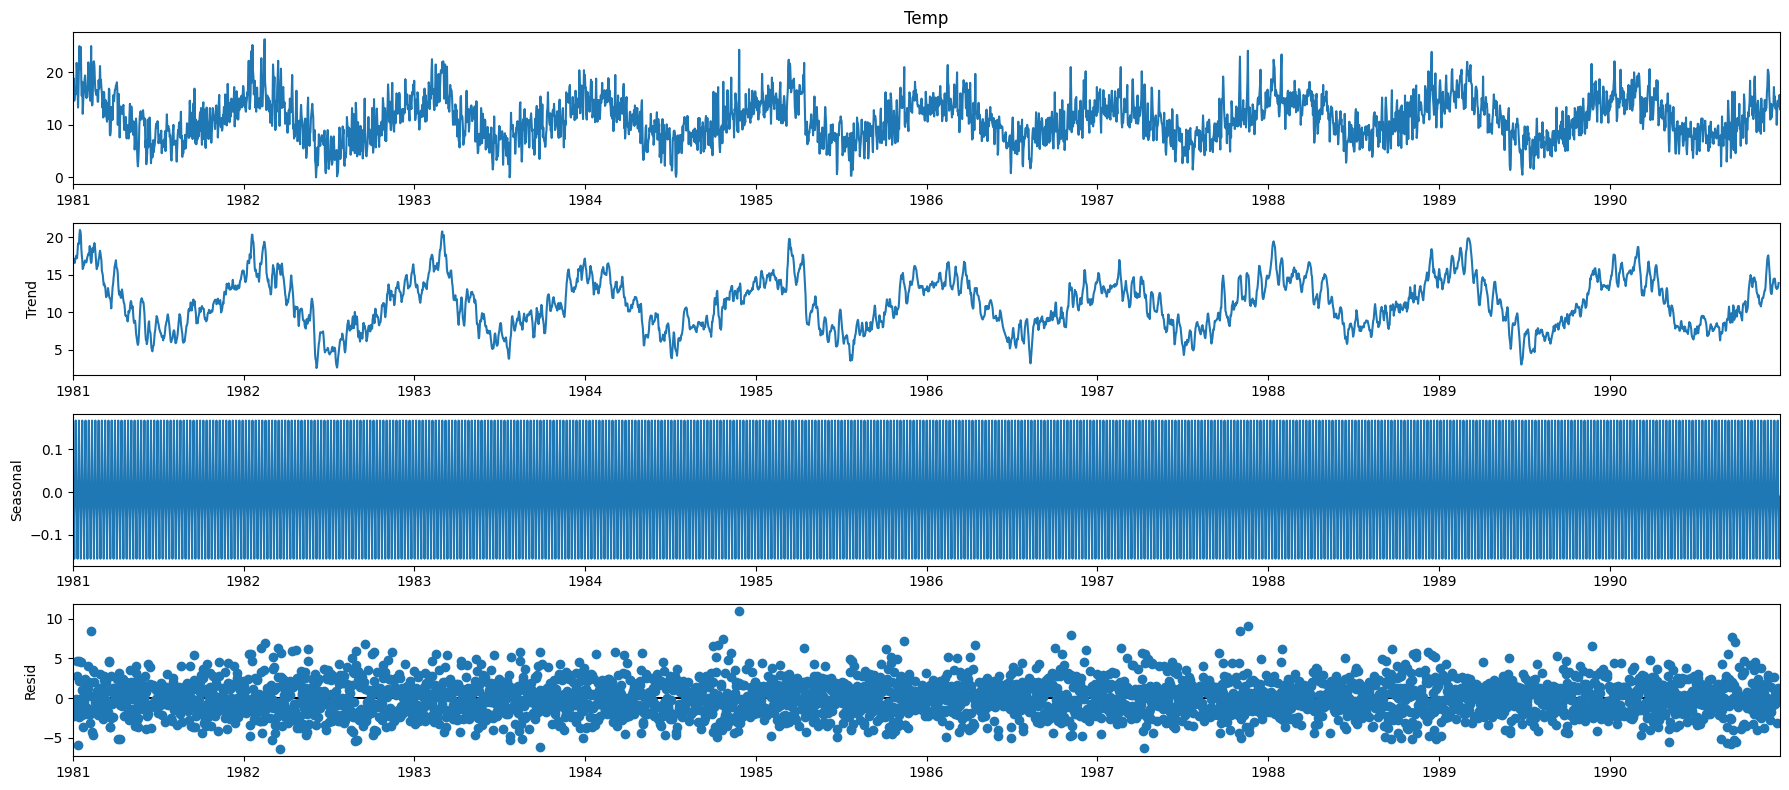

In [38]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data['Temp'], model='additive')
fig = decomposition.plot()
plt.show()

In the previous plot, several properties of the time series can be observed:

* There is no clear trend
* The seasonal component is almost null (pay attention to the y-axis scale)
* The residual component is quite high

Because of the second point, we can discard SARIMA models and focus only in non-seasonal ARIMA models.

On the other hand, the "residual" component can be as high as 10 degrees, therefore it will be very difficult to model this time series with an ARIMA. However, let's give it a try.

# ACF and PACF

To start creating ARIMA models, we need to know the ACF and PACF in order to start guessing some temptative values for the (p,d,q) parameters.

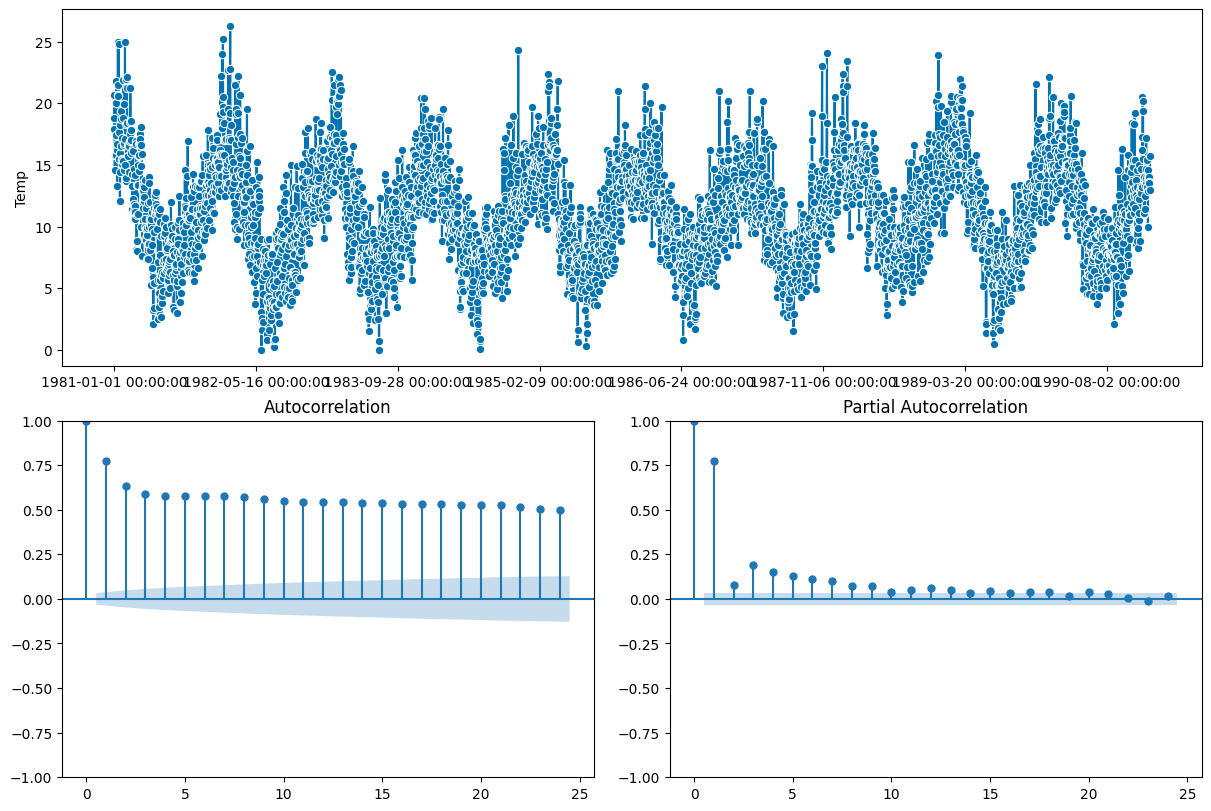

In [40]:
from sktime.utils.plotting import plot_series, plot_correlations, plot_lags

plot_correlations(pd.Series(data['Temp']));

The rule of dumb to determine potential values for the (p,d,q) of the ARIMA model after the inspection of the ACF and PACF is the summarized in the table below:

| Model | ACF | PACF |
|-------|-----|------|
| AR(p) | Decays slowly towards zero | Cutoff to zero at lag p |
| MA(q) | Cutoff to zero at lag q | Decays slowly towards zero |
| ARMA(p,q) | Decays slowly to zero | Decays slowly to zero |

Only in very lucky cases we will find the scenario of the first two rows. In general cases as this one, we will find the case of the last row.

According to the ACF plot, every value is highly related to the previous one. In addition, the PACF shows a clear peak at lag =1 while the others are much smaller. Considering both facts together, we can conclude that any point of the time series is pretty similar to the previous one. Thus, it looks reasonable to try to  predict each value adding an small "correction" to the previous one. This is suggesting us to use and AR(1) model, even though this could be too simple as there are other peaks outside the confidence bands.


Let's plot every value against the previous value. 

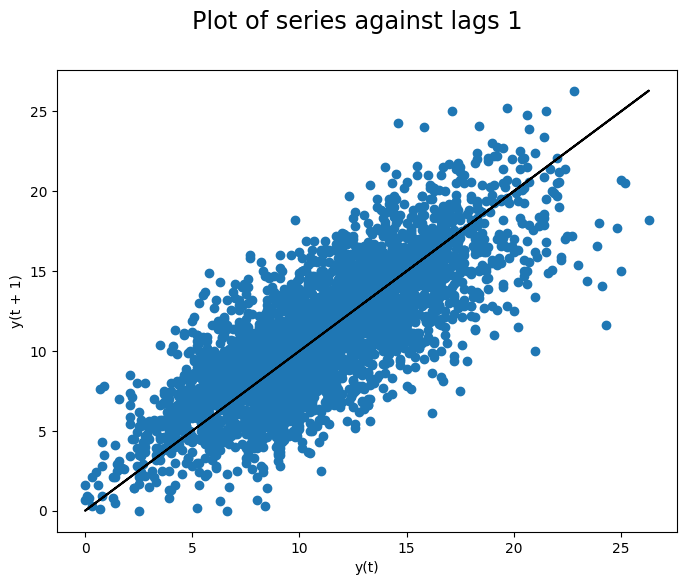

In [41]:
fig, ax = plot_lags(pd.Series(data['Temp']))
plt.plot(pd.Series(data['Temp']),pd.Series(data['Temp']),color="black")
plt.show()

It looks like that we can try to fit an autoregressive AR(1) model to predict the data:

$$\hat{y_{t}}=c+\phi_{1}y_{t-1}+\epsilon_{t}$$

where $\epsilon_{t}$ is the error made by the model at each time. It's interesting to compute the mean of the time series according to the model. Let's denote the mean with the symbol $<·>$.

$$<\hat{y_{t}}>=<c+\phi_{1}y_{t-1}+\epsilon_{t}>$$

the mean of a sum is the sum of the means, therefore:

$$<\hat{y_{t}}>=<c>+<\phi_{1}y_{t-1}>+<\epsilon_{t}>$$

we can simplify the previous expression because:

* $<c>=c$
* $<\phi_{1}y_{t-1}>=\phi_{1}<y_{t-1}>$
* $<\epsilon_{t}>=0$ (if our linear model is good enough)

therefore:

$$<\hat{y_{t}}>=c+\phi_{1}<y_{t-1}>$$

But the mean of the time series of a given time should be the same as the mean of the time series displaced one lag: $<\hat{y_{t}}>=<y_{t-1}>$. Let's represent the mean of the time series by $\mu$. Then, we have:

$$\mu=c+\phi_{1}\mu$$

if we re-arrage terms we end with:

$$\mu - \phi_{1}\mu=c$$

finally:

$$\mu = \frac{c}{(1-\phi_{1})}$$

then, we can clearly see that $\phi_{1}$ can't be one as otherwise the denominator will explode. This is what the ADF test is looking for.

In the original time series, the mean is not null.

In [42]:
data['Temp'].mean()

11.180024644030667

Therefore, $c\neq0$ in our model. 

# Train-test split

We can't split using the function train_test_split() because we will break the time dependence because we will introduce leaks. 

Instead, we can use two approaches:

* Manual
* With sktime functions

It's important to keep in mind that to generate a model, we need to use a Panda's Series in which the index is the "Date" and the values the variable to forecast.



Let's use the first approach: manual

In [43]:
import math 

# We split our data based on time, and we are going to use the first 80% of the total data to train and
# 20% to test the model.
max_train = math.ceil(len(data) * 0.80)
max_train

2922

In [44]:
train = data.iloc[:max_train,:]['Temp']
test  = data.iloc[max_train:,:]['Temp']

In [45]:
train.head()

1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Freq: D, Name: Temp, dtype: float64

We can do the same with sktime:

* temporal_train_test_split()

However, this function needs a pd.Series as an input

In [46]:
y_train, y_test = temporal_train_test_split(data['Temp'], train_size=0.8) # Predict from 1st July 2019

display(y_train.head())
display(y_test.head())

1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Freq: D, Name: Temp, dtype: float64

1988-12-31    14.45
1989-01-01    14.30
1989-01-02    17.40
1989-01-03    18.50
1989-01-04    16.80
Freq: D, Name: Temp, dtype: float64

In [47]:
y_test.index[-1]

Timestamp('1990-12-31 00:00:00', freq='D')

In [48]:
len(y_train)

2921

In [49]:
len(y_test)

731

Now let's finally fit an AR(1) model using the sktime library, and use it to forecast future values.

In [50]:
from sktime.forecasting.arima import ARIMA
# This function is fully equivalent to statsmodels SARIMAX

ar_1 = ARIMA(  
    order=(1, 0, 0), # Here we are setting (p=1, d=0, q=0)
    with_intercept=True, # We're area asking for a linear model with intercept
    suppress_warnings=True)

ar_1.fit(y_train)
print(ar_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2921
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6959.426
Date:                Thu, 18 May 2023   AIC                          13924.853
Time:                        13:00:12   BIC                          13942.792
Sample:                    01-01-1981   HQIC                         13931.314
                         - 12-30-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6207      0.142     18.460      0.000       2.342       2.899
ar.L1          0.7644      0.011     68.223      0.000       0.742       0.786
sigma2         6.8683      0.166     41.315      0.0

In [51]:
ar_1.get_fitted_params()

{'intercept': 2.6206987220132074,
 'ar.L1': 0.7643560137102138,
 'sigma2': 6.868335475553512,
 'aic': 13924.852654332644,
 'aicc': 13924.860881963772,
 'bic': 13942.791698239807,
 'hqic': 13931.314045174364}

The previous output tells us that the final model is:

$$\hat{y_{t}}=2.6207+0.7644y_{t-1}$$

Moreover, the p-values of the $intercept$ and $\phi_{1}=ar.L1$ are zero, which means that those coefficients are significant for the model. Now, we can compare the mean of the time series according to the mean of the model:

```python
2.6207/(1-0.7644)=11.12
```
therefore, in our case we obtain:

$$\mu=\frac{c}{(1-\phi_{1})}=11.12$$

while the real mean of the time series is: 11.18 pretty close value!!!


In addition, we the summary give us the AIC and the BIC:

* $AIC=13924.853$
* $BIC=13942.792$

the lower this values, the better.

Now, we need to set up our "Forecasting Horizon" to tell the library how many values we want to predict. We will evaluate our models based on their performance in the test set.

# Forecasting values

Now it's time to predict the train and test sets.

In [52]:
fh_train = fh = ForecastingHorizon(y_train.index, freq="D", is_relative=False)

print(fh_train)

ForecastingHorizon(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1988-12-21', '1988-12-22', '1988-12-23', '1988-12-24',
               '1988-12-25', '1988-12-26', '1988-12-27', '1988-12-28',
               '1988-12-29', '1988-12-30'],
              dtype='datetime64[ns]', length=2921, freq='D', is_relative=False)


In [53]:
fh_test = ForecastingHorizon(y_test.index, freq="D", is_relative=False)

print(fh_test)

ForecastingHorizon(['1988-12-31', '1989-01-01', '1989-01-02', '1989-01-03',
               '1989-01-04', '1989-01-05', '1989-01-06', '1989-01-07',
               '1989-01-08', '1989-01-09',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', length=731, freq='D', is_relative=False)


In [54]:
y_train_pred_ar_1 = ar_1.predict(fh_train)
y_train_pred_ar_1

1981-01-01    11.121433
1981-01-02    18.442868
1981-01-03    16.302671
1981-01-04    16.990592
1981-01-05    13.780297
                ...    
1988-12-26    14.697524
1988-12-27     9.882081
1988-12-28    12.480891
1988-12-29    12.480891
1988-12-30    13.933168
Freq: D, Name: Temp, Length: 2921, dtype: float64

In [55]:
y_test_pred_ar_1 = ar_1.predict(fh_test)  
y_test_pred_ar_1

1988-12-31    13.398119
1989-01-01    12.861631
1989-01-02    12.451564
1989-01-03    12.138126
1989-01-04    11.898549
                ...    
1990-12-27    11.121433
1990-12-28    11.121433
1990-12-29    11.121433
1990-12-30    11.121433
1990-12-31    11.121433
Freq: D, Name: Temp, Length: 731, dtype: float64

| Set | Temp |
|-----|------|
| Train | 11.2 |
| Train | 15.2 |
| ....  | .....|
| Test.  | 21.5 |

In [56]:
["Train"]*5 + ["Test"]*2

['Train', 'Train', 'Train', 'Train', 'Train', 'Test', 'Test']

In [57]:
results = pd.DataFrame({"Set":["Train"]*len(y_train)+["Test"]*len(y_test),
              "Temp":data['Temp'],
              "ARIMA(1,0,0)_Predicted":y_train_pred_ar_1.values.tolist()+y_test_pred_ar_1.values.tolist()})

results["ARIMA(1,0,0)_Residuals"] = results['Temp'] - results['ARIMA(1,0,0)_Predicted']
results = results.reset_index().rename(columns={"index":"Date"})
results.head()

,Date,Set,Temp,"ARIMA(1,0,0)_Predicted","ARIMA(1,0,0)_Residuals"
0,1981-01-01,Train,20.7,11.121433,9.578567
1,1981-01-02,Train,17.9,18.442868,-0.542868
2,1981-01-03,Train,18.8,16.302671,2.497329
3,1981-01-04,Train,14.6,16.990592,-2.390592
4,1981-01-05,Train,15.8,13.780297,2.019703


Now it's time to plot the forecast

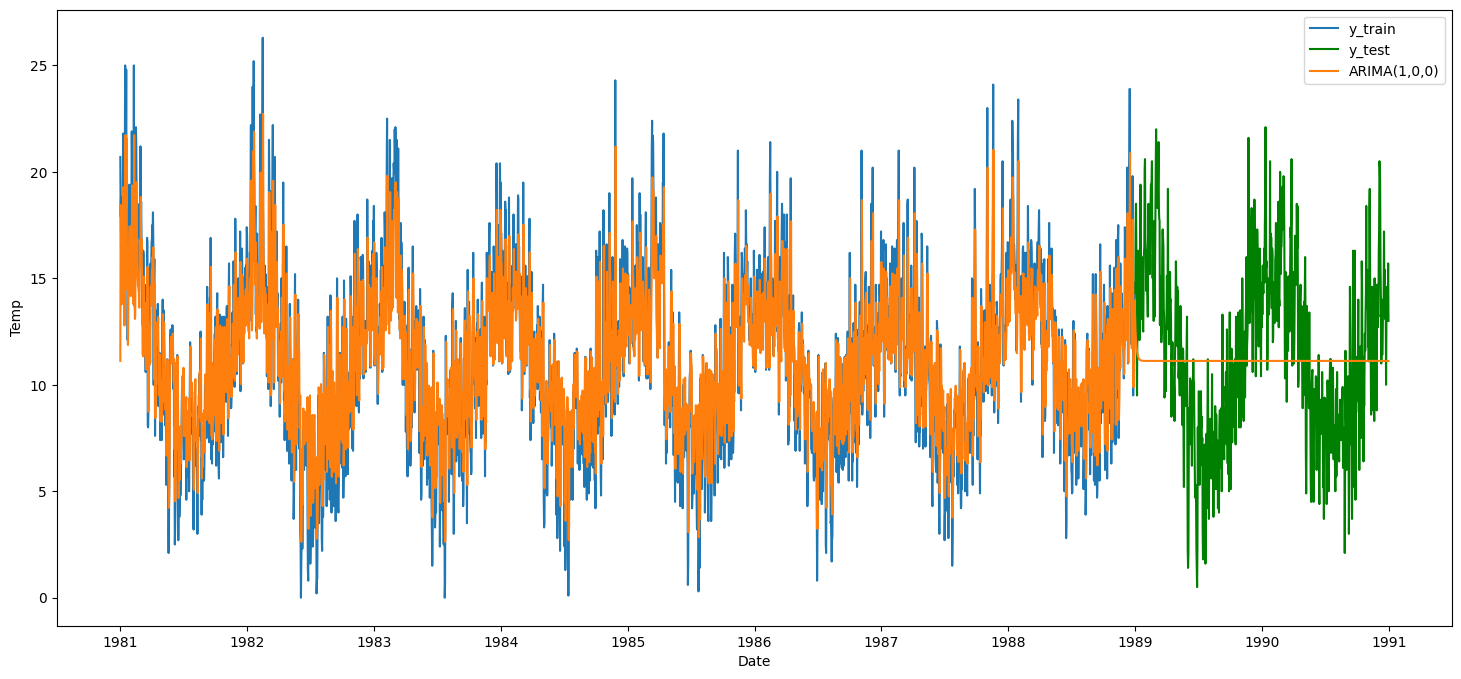

In [58]:
fig, ax = plt.subplots()
sns.lineplot(data=results[results['Set']=="Train"],x="Date",y="Temp",ax=ax, label = "y_train");
sns.lineplot(data=results[results['Set']=="Test"],x="Date",y="Temp",ax=ax, label = "y_test", color="green");
sns.lineplot(data=results,x="Date",y="ARIMA(1,0,0)_Predicted",ax=ax, label = "ARIMA(1,0,0)");
plt.show()

It turns out that the ARIMA(1,0,0) model produces a decent prediction for the TRAIN set but a terrible on the TEST set.

Now let's see what happens if we let the sktime library to estimate the best parameters for an SARIMA model.

In [59]:
ar_final = AutoARIMA(with_intercept=True, method="powell")
ar_final.fit(y_train)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



AutoARIMA(method='powell')

In [60]:
ar_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2921
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -6766.448
Date:                Thu, 18 May 2023   AIC                          13544.896
Time:                        13:18:51   BIC                          13580.775
Sample:                    01-01-1981   HQIC                         13557.819
                         - 12-30-1988                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1147      0.033      3.461      0.001       0.050       0.180
ar.L1          0.9897      0.003    348.533      0.000       0.984       0.995
ma.L1         -0.4062      0.017    -23.448      0.000      -0.440      -0.372
ma.L2         -0.3297      0.019    -17.632      0.000      -0.366      -0.293
ma.L3         -0.0969      0.018     -5.484      0.000      -0.132      -0.062
sigma2         6.0145      0.149     40.483      0.000       5.723       6.306
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.10
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The p-values of all the coefficients are close to zero.

In [61]:
ar_final.get_fitted_params()

{'intercept': 0.11466984273185546,
 'ar.L1': 0.9896522981123377,
 'ma.L1': -0.40623670051602667,
 'ma.L2': -0.329733731007924,
 'ma.L3': -0.09692797368856818,
 'sigma2': 6.014520711515889,
 'order': (1, 0, 3),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 13544.896430611916,
 'aicc': 13544.92525696744,
 'bic': 13580.774518426242,
 'hqic': 13557.819212295357}

This is telling us that the final model is an ARIMA(1,0,3) with intercept

which has the following expression:

$$\hat{y}_{t}= 0.115 + 0.990 * y_{t-1} - 0.406 * \epsilon_{t-1} -0.330 * \epsilon_{t-2} -0.097 * \epsilon_{t-3}$$

This AutoARIMA function tries to minimize the AIC using an LFBGS optimizer in order to estimate the coefficients of the ARIMA model. 

In addition, for this model the AIC is:

$$AIC[ARIMA(1,0,3)]=13544.89$$

which is smaller than our previous value:

$$AIC[ARIMA(1,0,0)]=13924.85$$

Now it's time to make predictions ofr the TRAIN and the TEST sets.

In [62]:
y_train_pred_ar_final = ar_final.predict(fh_train)  
y_train_pred_ar_final

1981-01-01    11.081672
1981-01-02    18.173847
1981-01-03    16.406056
1981-01-04    17.671863
1981-01-05    14.947333
                ...    
1988-12-26    15.119331
1988-12-27    12.029292
1988-12-28    14.548878
1988-12-29    13.808588
1988-12-30    14.818071
Freq: D, Name: Temp, Length: 2921, dtype: float64

In [63]:
y_test_pred_ar_final = ar_final.predict(fh_test)  
y_test_pred_ar_final

1988-12-31    14.193394
1989-01-01    14.301872
1989-01-02    14.338151
1989-01-03    14.304454
1989-01-04    14.271106
                ...    
1990-12-27    11.083419
1990-12-28    11.083401
1990-12-29    11.083383
1990-12-30    11.083365
1990-12-31    11.083348
Freq: D, Name: Temp, Length: 731, dtype: float64

Now, let's update our dataframe with the results to visualize them.

In [64]:
results["ARIMA(1,0,3)_Predicted"] = y_train_pred_ar_final.values.tolist() + y_test_pred_ar_final.values.tolist()
results["ARIMA(1,0,3)_Residuals"] = results['Temp'] - results["ARIMA(1,0,3)_Predicted"]
results.head()

,Date,Set,Temp,"ARIMA(1,0,0)_Predicted","ARIMA(1,0,0)_Residuals","ARIMA(1,0,3)_Predicted","ARIMA(1,0,3)_Residuals"
0,1981-01-01,Train,20.7,11.121433,9.578567,11.081672,9.618328
1,1981-01-02,Train,17.9,18.442868,-0.542868,18.173847,-0.273847
2,1981-01-03,Train,18.8,16.302671,2.497329,16.406056,2.393944
3,1981-01-04,Train,14.6,16.990592,-2.390592,17.671863,-3.071863
4,1981-01-05,Train,15.8,13.780297,2.019703,14.947333,0.852667


Now let's plot the ARIMA(1,0,3) model predictions.

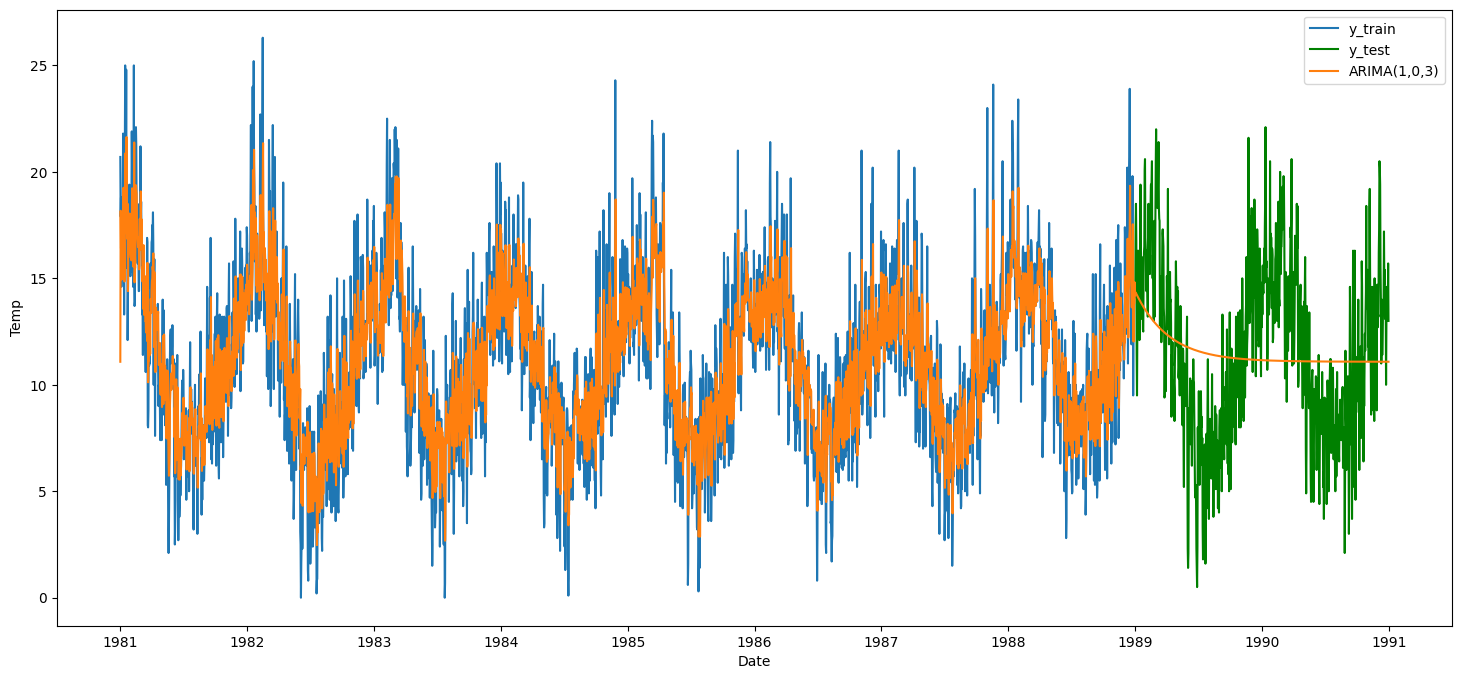

In [65]:
fig, ax = plt.subplots()
sns.lineplot(data=results[results['Set']=="Train"],x="Date",y="Temp",ax=ax, label = "y_train");
sns.lineplot(data=results[results['Set']=="Test"],x="Date",y="Temp",ax=ax, label = "y_test", color="green");
sns.lineplot(data=results,x="Date",y="ARIMA(1,0,3)_Predicted",ax=ax, label = "ARIMA(1,0,3)");
plt.show()

Again, as it can be seen this new ARIMA(1,0,3) model is unable to provide a good prediction in the TEST set. This kind of behaviour is quite typical from in ARIMA models when we try to forecast lots of values in the future. In addittion, the more values we predict in the future, the less reliable are our predictions.

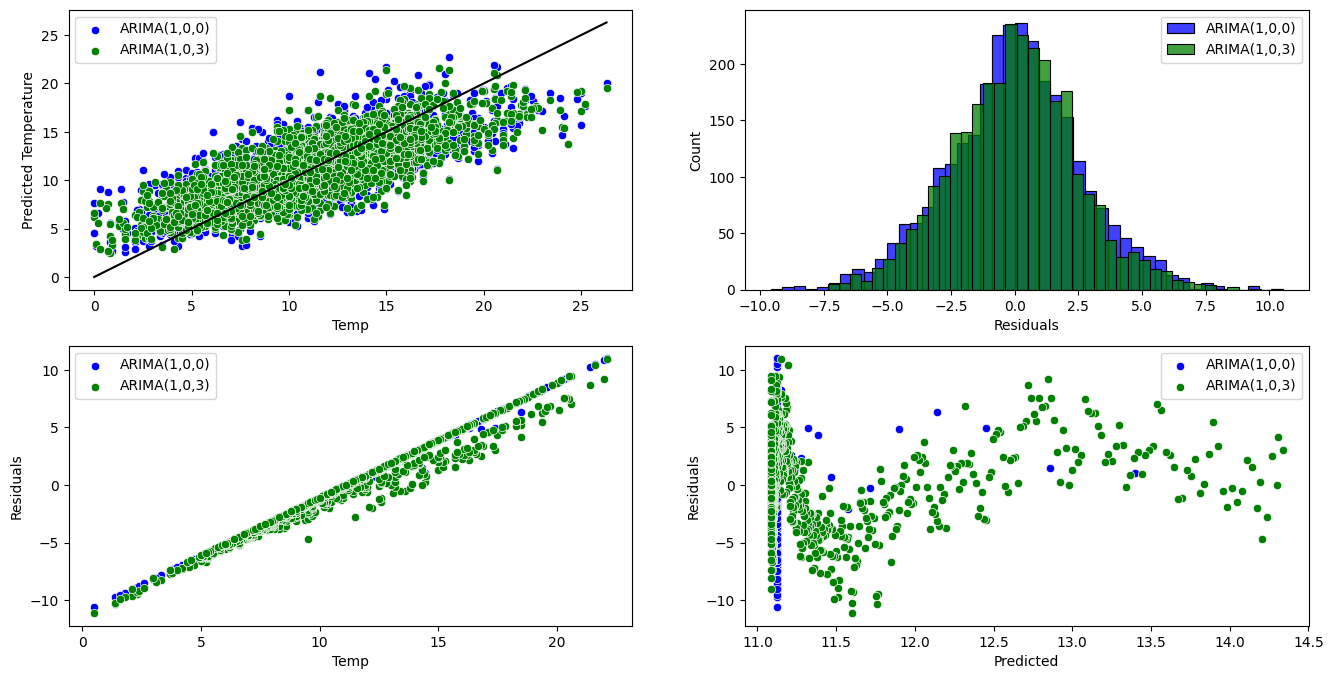

In [66]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
sns.scatterplot(data = results[results["Set"]=="Train"],x="Temp", y="ARIMA(1,0,0)_Predicted",ax=ax[0,0],color="blue",label ="ARIMA(1,0,0)");
sns.scatterplot(data = results[results["Set"]=="Train"],x="Temp", y="ARIMA(1,0,3)_Predicted",ax=ax[0,0],color="green",label="ARIMA(1,0,3)");
sns.lineplot(data= results[results["Set"]=="Train"],x="Temp",y="Temp",color='black' ,ax=ax[0,0]);
ax[0,0].set_ylabel("Predicted Temperature")
sns.histplot(data = results[results["Set"]=="Train"], x="ARIMA(1,0,0)_Residuals",ax=ax[0,1],color ="blue",label="ARIMA(1,0,0)");
sns.histplot(data = results[results["Set"]=="Train"], x="ARIMA(1,0,3)_Residuals",ax=ax[0,1],color ="green",label="ARIMA(1,0,3)");
ax[0,1].set_xlabel("Residuals")
ax[0,1].legend()
sns.scatterplot(data = results[results["Set"]=="Test"], y="ARIMA(1,0,0)_Residuals", x="Temp",ax=ax[1,0],color="blue",label ="ARIMA(1,0,0)");
sns.scatterplot(data = results[results["Set"]=="Test"], y="ARIMA(1,0,3)_Residuals", x="Temp",ax=ax[1,0],color="green",label ="ARIMA(1,0,3)");
ax[1,0].set_ylabel("Residuals")
ax[1,0].legend()
sns.scatterplot(data = results[results["Set"]=="Test"], y="ARIMA(1,0,0)_Residuals", x="ARIMA(1,0,0)_Predicted",ax=ax[1,1],color="blue",label ="ARIMA(1,0,0)");
sns.scatterplot(data = results[results["Set"]=="Test"], y="ARIMA(1,0,3)_Residuals", x="ARIMA(1,0,3)_Predicted",ax=ax[1,1],color="green",label ="ARIMA(1,0,3)");
ax[1,1].set_xlabel("Predicted")
ax[1,1].set_ylabel("Residuals")
ax[1,1].legend()
plt.show()

Let's see how it looks like

# Computing error metrics

In [67]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

mase = MeanAbsoluteScaledError()
mase(y_train, y_train_pred_ar_1, y_train=y_train)

0.9337253717221266

To simplify too much, let's ignore the seasonality and lets compute the MASE defined as:

$$MASE=mean\left ( \frac{|y(t)-\hat{y}(t)|_{train}}{\frac{1}{(N-1)}\sum_{t=2}|y_{t}-y_{t-1}|_{train}}\right )=\frac{MAE_{train}}{MAE_{train,Naïve}}$$

We can interpretate the denominator as the mean absolute error of a model which allways predicts the previous value, ie:

$$|y_{t}-\hat{y}(t)|_{train} = |y_{t}-y_{t-1}|_{train}$$

Let's see how to compute this manually. We will start computing the term in the denominator

In [68]:
results['naive'] = np.abs(results["Temp"]-results["Temp"].shift())
results.head()

,Date,Set,Temp,"ARIMA(1,0,0)_Predicted","ARIMA(1,0,0)_Residuals","ARIMA(1,0,3)_Predicted","ARIMA(1,0,3)_Residuals",naive
0,1981-01-01,Train,20.7,11.121433,9.578567,11.081672,9.618328,NaN
1,1981-01-02,Train,17.9,18.442868,-0.542868,18.173847,-0.273847,2.8
2,1981-01-03,Train,18.8,16.302671,2.497329,16.406056,2.393944,0.9
3,1981-01-04,Train,14.6,16.990592,-2.390592,17.671863,-3.071863,4.2
4,1981-01-05,Train,15.8,13.780297,2.019703,14.947333,0.852667,1.2


In [69]:
quotient_train = results[results['Set']=="Train"]['naive'].mean()
quotient_test = results[results['Set']=="Test"]['naive'].mean()
print("The MAE of the Naive model in the Train set is {:.2f}".format(quotient_train))
print("The MAE of the Naive model in the Test set is {:.2f}".format(quotient_test))

The MAE of the Naive model in the Train set is 2.18
The MAE of the Naive model in the Test set is 1.95


Now, the numerator:

In [70]:
results.loc[results["Set"]=="Train",'ARIMA(1,0,0)_q'] = np.abs(results['ARIMA(1,0,0)_Residuals'])/quotient_train
results.loc[results["Set"]=="Train",'ARIMA(1,0,3)_q'] = np.abs(results['ARIMA(1,0,3)_Residuals'])/quotient_train

results.loc[results["Set"]=="Test",'ARIMA(1,0,0)_q'] = np.abs(results['ARIMA(1,0,0)_Residuals'])/quotient_test
results.loc[results["Set"]=="Test",'ARIMA(1,0,3)_q'] = np.abs(results['ARIMA(1,0,3)_Residuals'])/quotient_test
results.head()

,Date,Set,Temp,"ARIMA(1,0,0)_Predicted","ARIMA(1,0,0)_Residuals","ARIMA(1,0,3)_Predicted","ARIMA(1,0,3)_Residuals",naive,"ARIMA(1,0,0)_q","ARIMA(1,0,3)_q"
0,1981-01-01,Train,20.7,11.121433,9.578567,11.081672,9.618328,NaN,4.398814,4.417073
1,1981-01-02,Train,17.9,18.442868,-0.542868,18.173847,-0.273847,2.8,0.249304,0.125760
2,1981-01-03,Train,18.8,16.302671,2.497329,16.406056,2.393944,0.9,1.146861,1.099383
3,1981-01-04,Train,14.6,16.990592,-2.390592,17.671863,-3.071863,4.2,1.097843,1.410707
4,1981-01-05,Train,15.8,13.780297,2.019703,14.947333,0.852667,1.2,0.927519,0.391574


In [71]:
MASE_ARIMA100_train = results.loc[results["Set"]=="Train",'ARIMA(1,0,0)_q'].mean()
MASE_ARIMA100_test  = results.loc[results["Set"]=="Test",'ARIMA(1,0,0)_q'].mean()

MASE_ARIMA103_train = results.loc[results["Set"]=="Train",'ARIMA(1,0,3)_q'].mean()
MASE_ARIMA103_test  = results.loc[results["Set"]=="Test",'ARIMA(1,0,3)_q'].mean()

MASE_ARIMA100_train_sk = mase(y_train, y_train_pred_ar_1, y_train=y_train)
MASE_ARIMA100_test_sk  = mase(y_test, y_test_pred_ar_1, y_train=y_test)

MASE_ARIMA103_train_sk = mase(y_train, y_train_pred_ar_final, y_train=y_train)
MASE_ARIMA103_test_sk  = mase(y_test, y_test_pred_ar_final, y_train=y_test)

print("The MASE of the ARIMA(1,0,0) model in the TRAIN set is: {:.2f}".format(MASE_ARIMA100_train))
print("The MASE of the ARIMA(1,0,0) model in the TEST set is: {:.2f}".format(MASE_ARIMA100_test))

# To double check with sktime
print("The MASE of the ARIMA(1,0,0) model in the TRAIN set is: {:.2f}".format(MASE_ARIMA100_train_sk))
print("The MASE of the ARIMA(1,0,0) model in the TEST set is: {:.2f}".format(MASE_ARIMA100_test_sk))

print()
print("-------------------------------")
print()
print("The MASE of the ARIMA(1,0,3) model in the TRAIN set is: {:.2f}".format(MASE_ARIMA103_train))
print("The MASE of the ARIMA(1,0,3) model in the TEST set is: {:.2f}".format(MASE_ARIMA103_test))

# To double check with sktime
print("The MASE of the ARIMA(1,0,3) model in the TRAIN set is: {:.2f}".format(MASE_ARIMA103_train_sk))
print("The MASE of the ARIMA(1,0,3) model in the TEST set is: {:.2f}".format(MASE_ARIMA103_test_sk))

The MASE of the ARIMA(1,0,0) model in the TRAIN set is: 0.93
The MASE of the ARIMA(1,0,0) model in the TEST set is: 1.74
The MASE of the ARIMA(1,0,0) model in the TRAIN set is: 0.93
The MASE of the ARIMA(1,0,0) model in the TEST set is: 1.73

-------------------------------

The MASE of the ARIMA(1,0,3) model in the TRAIN set is: 0.88
The MASE of the ARIMA(1,0,3) model in the TEST set is: 1.66
The MASE of the ARIMA(1,0,3) model in the TRAIN set is: 0.88
The MASE of the ARIMA(1,0,3) model in the TEST set is: 1.66


From the results, we can see that both models are better than the Naïve model on the TRAIN set, but not so in the TEST set.

# Checking the correlations of the errors

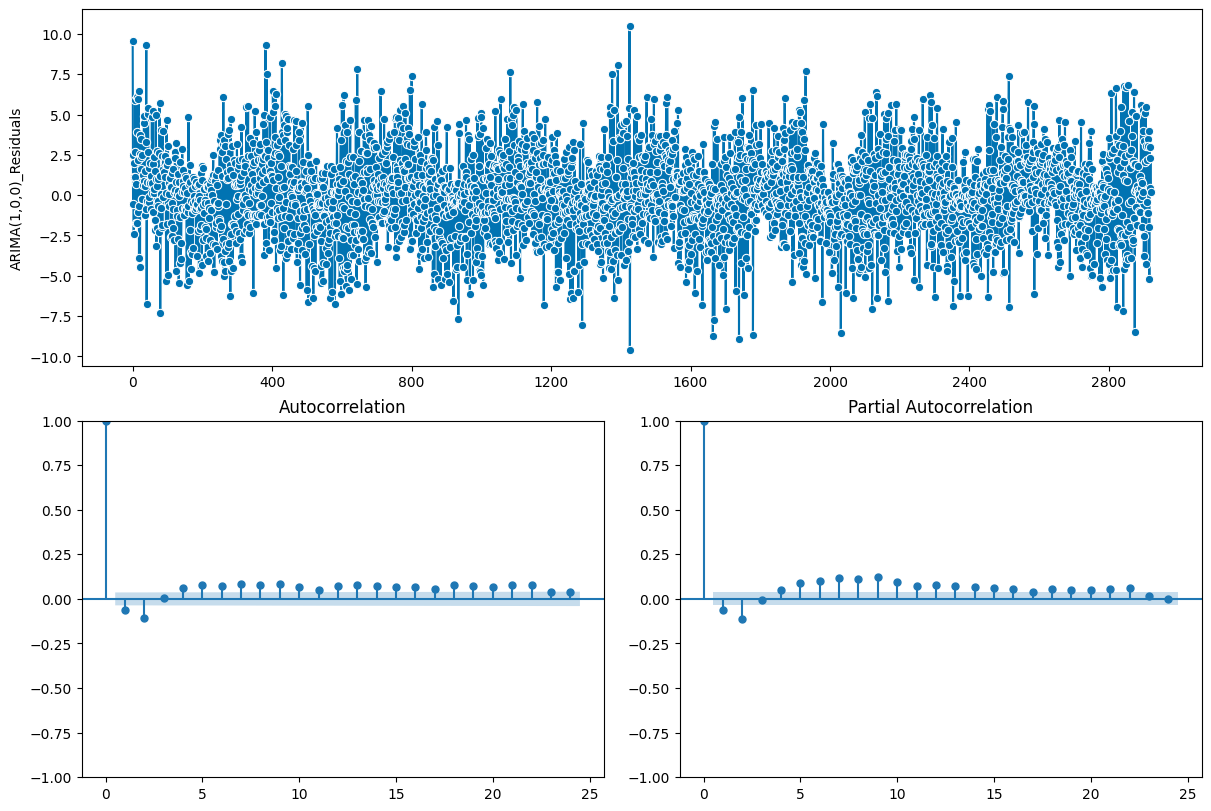

In [72]:
plot_correlations(results.loc[results['Set']=="Train",'ARIMA(1,0,0)_Residuals']);

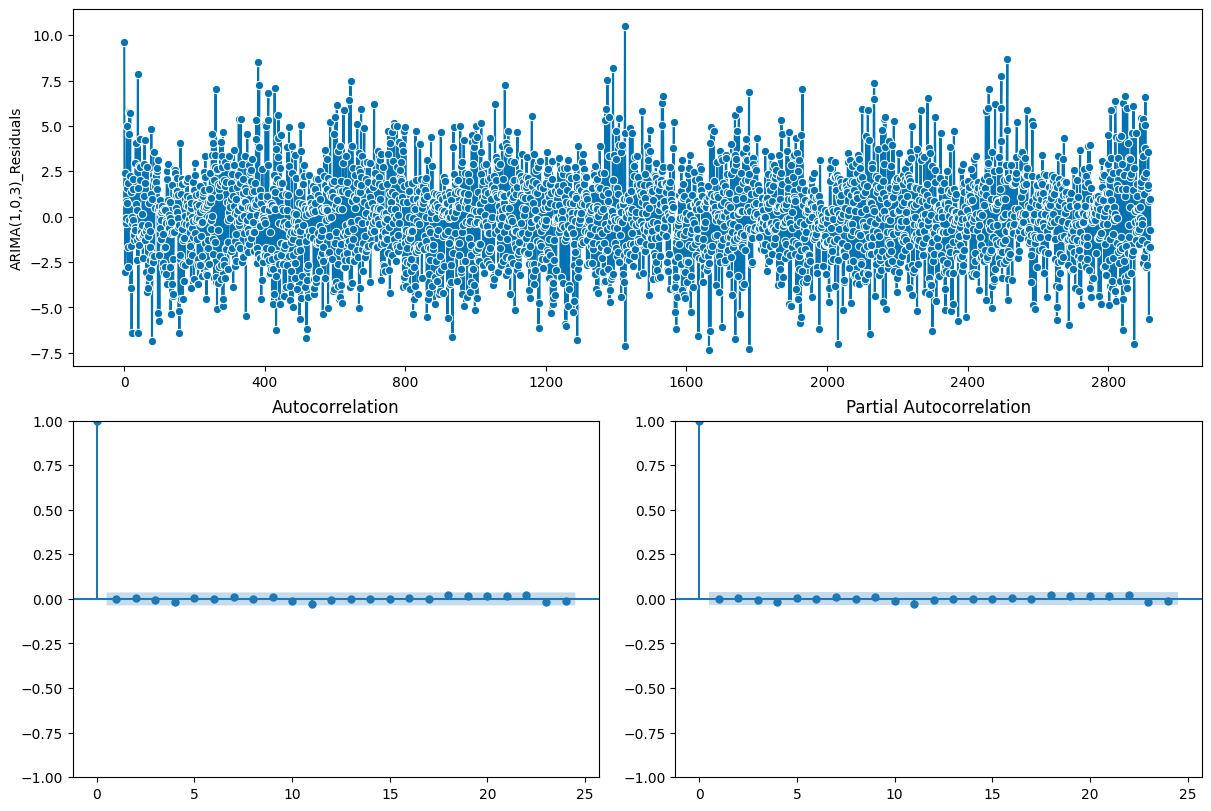

In [73]:
plot_correlations(results.loc[results['Set']=="Train",'ARIMA(1,0,3)_Residuals']);

# Other techniques to perform the train-test split

In general, the more data used for training, the better. However, in time series that might not be the case because if we use too old data, the time series might show a different pattern than the most recent data. To prevent this problem, another approach is to split the data in small training "windows" and try to predict a few values ahead of the "window". Within this approach, we can find two strategies:

* fixed size, sliding window
* increasing window size

In the first strategy, we use a (training) "window" of fixed size N to train the model. Then, the trained model is used to predict a few values ahead n < N (testing). Next, the training "window" is displaced one lag into the future and the model is trained again. Finally, the model is evaluated onto the next n values and the whole process is repeated over and over.

In the second strategy, the starting point of the training "window" is fixed but the size of the "window" is increased one lag into the future after the model training and the testing set is also displaced one lag into the future. 

In both strategies, it's possible to provide a better estimation of model performance averaging the model's performance obtained in each testing window.

Let's see how we can do this.

In [ ]:
from sktime.forecasting.all import *
from sktime.forecasting.model_evaluation import evaluate

window_length = 365 * 4 # Four years used for training

# Here the forecasting horizon is defined in terms of lags RELATIVE to the last
# value of the training set.
fh_cv = ForecastingHorizon([1,2,3,4]) # Four days for testing set.

forecaster_ar_1 = ARIMA(order=(1, 0, 0), # Here we are setting (p=1, d=0, q=0)
    with_intercept=True, # We're area asking for a linear model with intercept
    suppress_warnings=True)

cv = SlidingWindowSplitter(window_length=window_length, fh=fh_cv)
n_splits = cv.get_n_splits(data['Temp'])
#n_splits
mase_cv = MeanAbsoluteScaledError()
out_ARIMA100 = evaluate(forecaster_ar_1, cv, data['Temp'], scoring=mase_cv) # We use the full time series here.


<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_modul

In [ ]:
out_ARIMA100.describe()

,test_MeanAbsoluteScaledError,fit_time,pred_time,len_train_window
count,2189.000000,2189.000000,2189.000000,2189.0
mean,1.118054,0.180451,0.016305,1460.0
std,0.585632,0.063404,0.003277,0.0
min,0.088330,0.088380,0.012327,1460.0
25%,0.691643,0.150077,0.013827,1460.0
50%,1.007886,0.162959,0.015107,1460.0
75%,1.437507,0.184740,0.018421,1460.0
max,4.442953,0.394572,0.032654,1460.0


Thus, we can see that on average the predictons of for a four days of the ARIMA(1,0,0) model are not quite better than the Naïve model (predicts the previous value in the series). 

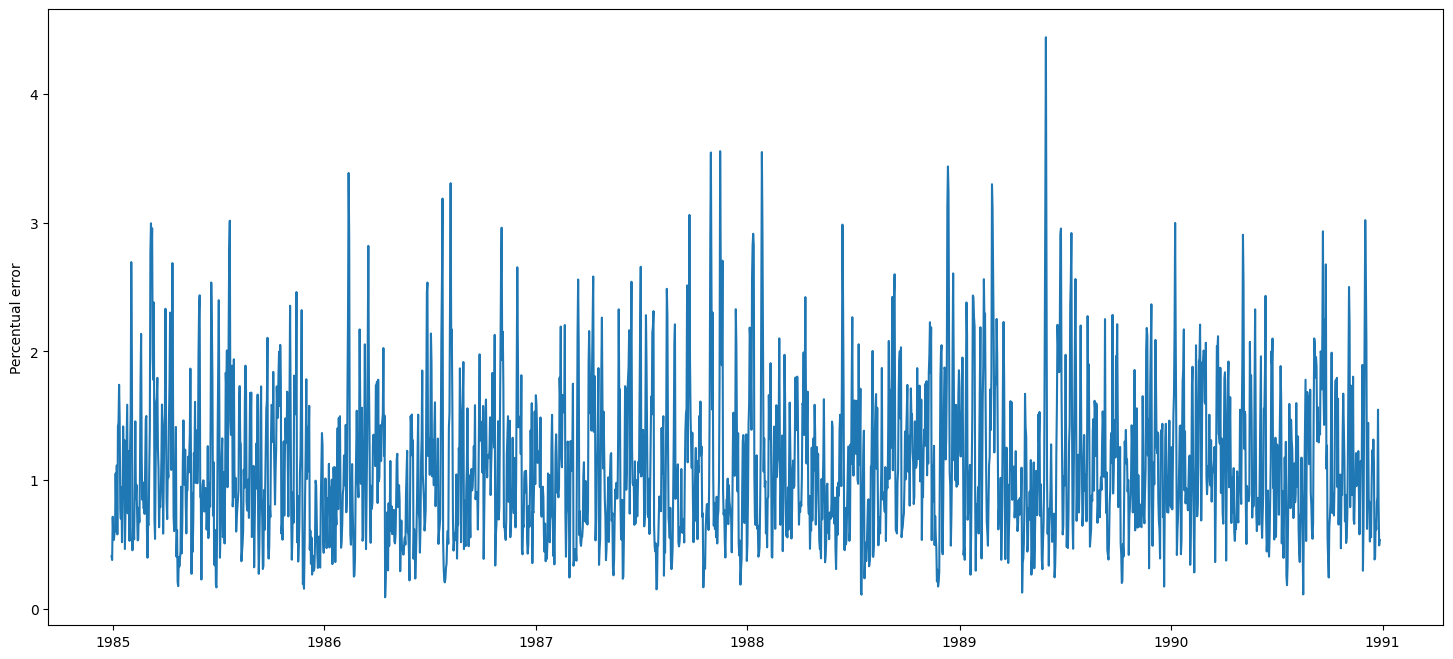

In [ ]:
fig, ax = plt.subplots()
ax.plot(out_ARIMA100["cutoff"],out_ARIMA100["test_MeanAbsoluteScaledError"])
ax.set_ylabel("Percentual error")
plt.show()

# Facebook's Prophet model

In [74]:
from sktime.forecasting.fbprophet import Prophet

In [75]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV



In [76]:
forecaster_prophet = Prophet(seasonality_mode='additive',n_changepoints=25)
    #add_country_holidays={'country_name': 'Germany'},
    #yearly_seasonality="Auto")
forecaster_prophet.fit(y_train)  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntrsveqo/x5qpaczp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntrsveqo/5508yvj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72381', 'data', 'file=/tmp/tmpntrsveqo/x5qpaczp.json', 'init=/tmp/tmpntrsveqo/5508yvj2.json', 'output', 'file=/tmp/tmpntrsveqo/prophet_modelc5c0hhsk/prophet_model-20230518135652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:56:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet()

In [77]:
forecaster_prophet.get_params()

{'add_country_holidays': None,
 'add_seasonality': None,
 'alpha': 0.05,
 'changepoint_prior_scale': 0.05,
 'changepoint_range': 0.8,
 'changepoints': None,
 'daily_seasonality': 'auto',
 'freq': None,
 'growth': 'linear',
 'growth_cap': None,
 'growth_floor': 0.0,
 'holidays': None,
 'holidays_prior_scale': 10.0,
 'mcmc_samples': 0,
 'n_changepoints': 25,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10.0,
 'stan_backend': None,
 'uncertainty_samples': 1000,
 'verbose': 0,
 'weekly_seasonality': 'auto',
 'yearly_seasonality': 'auto'}

Now it's time to update our results dataframe.

In [78]:
results.loc[results["Set"]=="Train","Prophet_Predicted"] = forecaster_prophet.predict(fh_train).values
results.loc[results["Set"]=="Test","Prophet_Predicted"]  = forecaster_prophet.predict(fh_test).values

In [79]:
results["Prophet_Residuals"] = results["Temp"] - results["Prophet_Predicted"]
results.loc[results["Set"]=="Train","Prophet_q"] = np.abs(results.loc[results["Set"]=="Train","Prophet_Residuals"])/quotient_train
results.loc[results["Set"]=="Test","Prophet_q"]  = np.abs(results.loc[results["Set"]=="Test","Prophet_Residuals"])/quotient_test
results.head()

,Date,Set,Temp,"ARIMA(1,0,0)_Predicted","ARIMA(1,0,0)_Residuals","ARIMA(1,0,3)_Predicted","ARIMA(1,0,3)_Residuals",naive,"ARIMA(1,0,0)_q","ARIMA(1,0,3)_q",Prophet_Predicted,Prophet_Residuals,Prophet_q
0,1981-01-01,Train,20.7,11.121433,9.578567,11.081672,9.618328,NaN,4.398814,4.417073,15.477140,5.222860,2.398520
1,1981-01-02,Train,17.9,18.442868,-0.542868,18.173847,-0.273847,2.8,0.249304,0.125760,15.580479,2.319521,1.065205
2,1981-01-03,Train,18.8,16.302671,2.497329,16.406056,2.393944,0.9,1.146861,1.099383,15.600651,3.199349,1.469253
3,1981-01-04,Train,14.6,16.990592,-2.390592,17.671863,-3.071863,4.2,1.097843,1.410707,15.501189,-0.901189,0.413858
4,1981-01-05,Train,15.8,13.780297,2.019703,14.947333,0.852667,1.2,0.927519,0.391574,15.788296,0.011704,0.005375


In [80]:
mase = MeanAbsoluteScaledError()
mase(y_train, results.loc[results["Set"]=="Train","Prophet_Predicted"], y_train=y_train)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:458: UserWarning:

y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:469: UserWarning:

y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.



0.9969241016142837

In [81]:
mase(y_test, results.loc[results["Set"]=="Test","Prophet_Predicted"], y_train=y_test)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:458: UserWarning:

y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:469: UserWarning:

y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.



1.2121860804264335

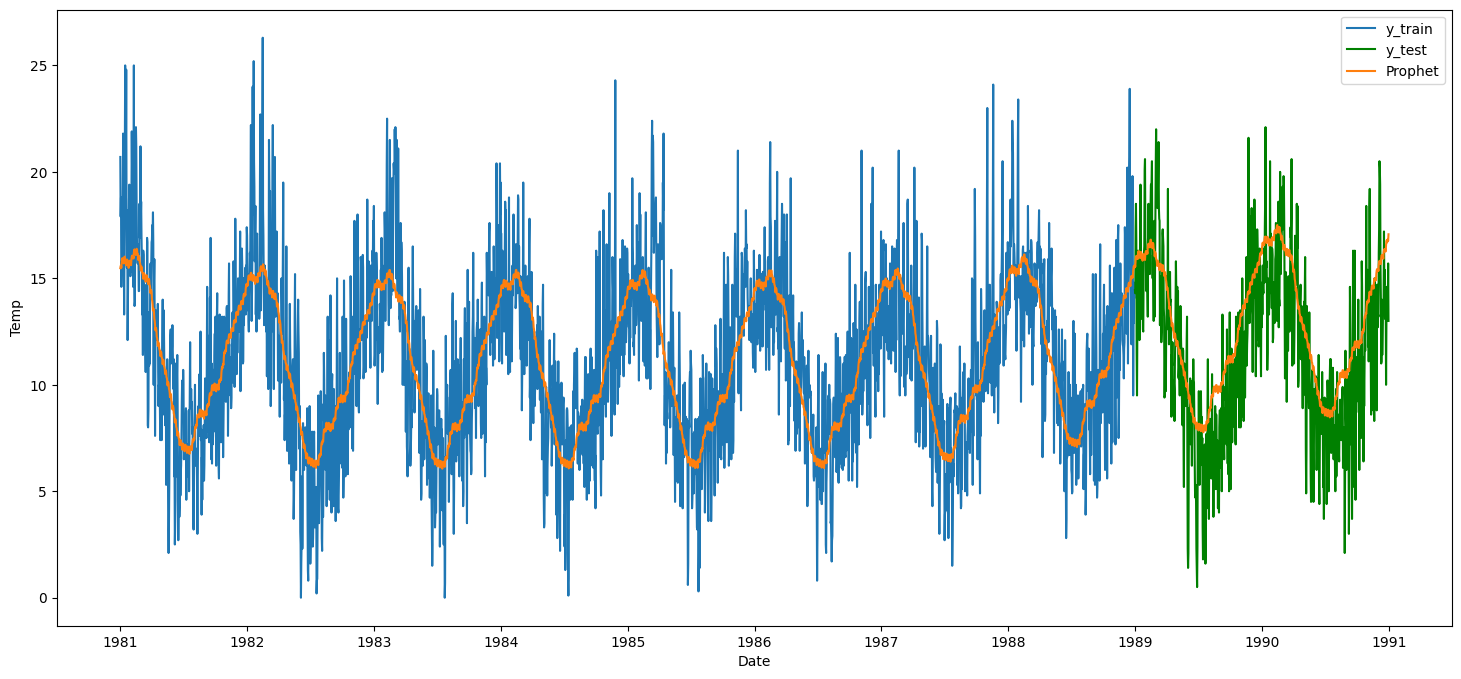

In [82]:
fig, ax = plt.subplots()
sns.lineplot(data=results[results['Set']=="Train"],x="Date",y="Temp",ax=ax, label = "y_train");
sns.lineplot(data=results[results['Set']=="Test"],x="Date",y="Temp",ax=ax, label = "y_test", color="green");
sns.lineplot(data=results,x="Date",y="Prophet_Predicted",ax=ax, label = "Prophet");
plt.show()

# Extending the predictions

Now it's time to use the Prophet model to forecast new values in the future. 

In [83]:
y_test

1988-12-31    14.45
1989-01-01    14.30
1989-01-02    17.40
1989-01-03    18.50
1989-01-04    16.80
              ...  
1990-12-27    14.00
1990-12-28    13.60
1990-12-29    13.50
1990-12-30    15.70
1990-12-31    13.00
Freq: D, Name: Temp, Length: 731, dtype: float64

In [84]:
ForecastingHorizon([1,2,3,4,5,6], freq="D", is_relative=True)

ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True)

In [85]:
ForecastingHorizon(pd.PeriodIndex(pd.date_range(start="1991-1-1", periods=6, freq="D")), is_relative=False )

ForecastingHorizon(['1991-01-01', '1991-01-02', '1991-01-03', '1991-01-04',
             '1991-01-05', '1991-01-06'],
            dtype='period[D]', is_relative=False)

In [86]:
y_test

1988-12-31    14.45
1989-01-01    14.30
1989-01-02    17.40
1989-01-03    18.50
1989-01-04    16.80
              ...  
1990-12-27    14.00
1990-12-28    13.60
1990-12-29    13.50
1990-12-30    15.70
1990-12-31    13.00
Freq: D, Name: Temp, Length: 731, dtype: float64

In [87]:
fh_twelve_days = ForecastingHorizon([732,733,734,735,736,737,738,739,740,741,742,743], freq="D", is_relative=True)
#fh_six_months
y_pred_twelve_days = forecaster_prophet.predict(fh_twelve_days)
y_pred_twelve_days_df = pd.DataFrame(y_pred_twelve_days).reset_index().rename(
    columns={"index":"Date", 0:"Pred"})
y_pred_twelve_days_df

,Date,Temp
0,1991-01-01,17.224014
1,1991-01-02,17.290881
2,1991-01-03,17.184931
3,1991-01-04,17.285956
4,1991-01-05,17.302665
5,1991-01-06,17.198727
6,1991-01-07,17.480521
7,1991-01-08,17.600899
8,1991-01-09,17.628684
9,1991-01-10,17.480197


Finally, let's plot the predictions.

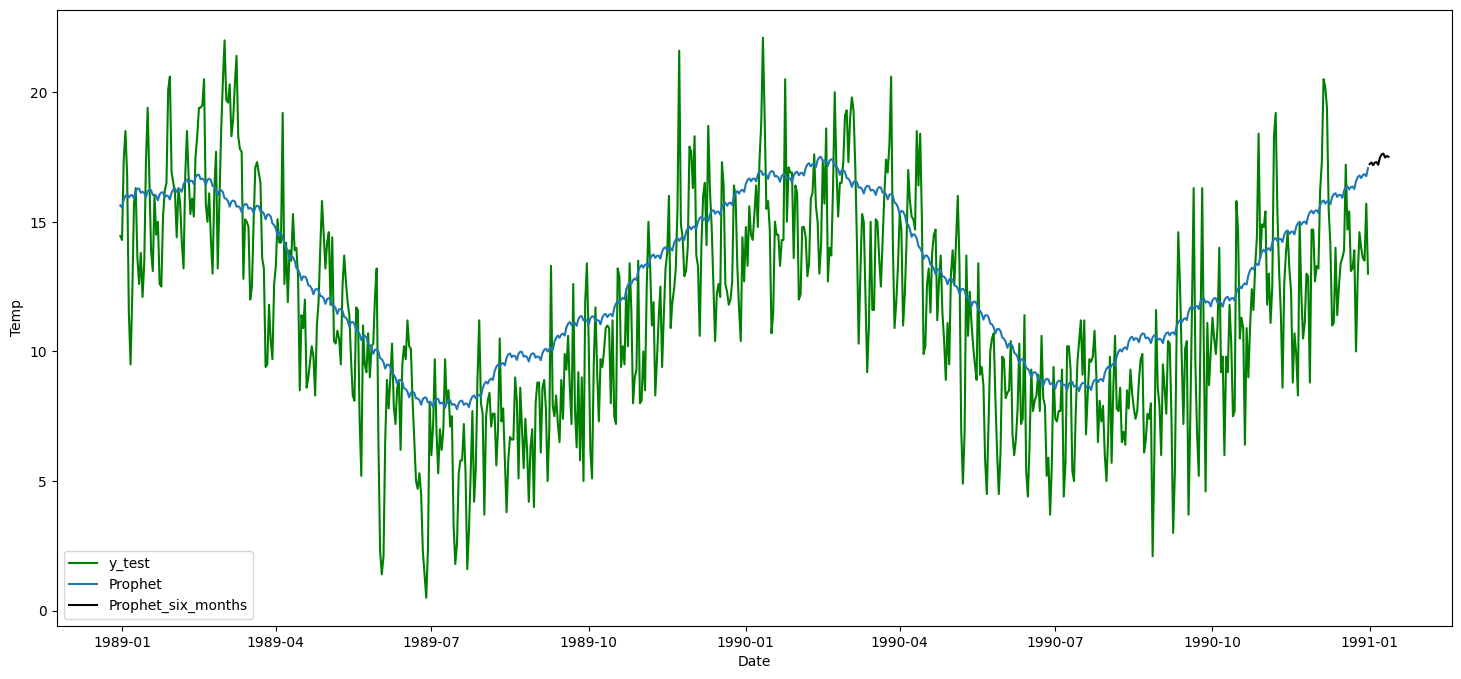

In [88]:
fig, ax = plt.subplots()

sns.lineplot(data=results[results['Set']=="Test"],x="Date",y="Temp",ax=ax, label = "y_test", color="green");
sns.lineplot(data=results[results['Set']=="Test"],x="Date",y="Prophet_Predicted",ax=ax, label = "Prophet");
sns.lineplot(data=y_pred_twelve_days_df,x="Date",y="Temp",ax=ax, label = "Prophet_six_months", color="black");
plt.show()

In [89]:
results.loc[:,results.columns.str.contains("Residuals")].describe()

,"ARIMA(1,0,0)_Residuals","ARIMA(1,0,3)_Residuals",Prophet_Residuals
count,3652.000000,3652.000000,3652.000000
mean,0.065089,-0.009988,-0.279035
std,2.980347,2.819709,2.767536
min,-10.621433,-11.098297,-8.447770
25%,-1.817279,-1.841444,-2.208828
50%,0.041484,-0.009807,-0.380179
75%,1.896831,1.753594,1.500682
max,10.978567,10.951761,11.694708


On the table above, can see that on average the ARIMA models have smaller mean and median residuals showing more exact predictions than the Prophet model. In contrast, the standard deviations from the ARIMA models are slightly higher than the value obtained with the Prophet model. ARIMA and Prophet models show similar extreme values (min and max) values for the residuals pointing out the difficulties of predicting temperature values with such high fluctuations.

In [90]:
y_train.std(), y_test.std()

(4.061011826740762, 4.105281826759839)